# Project Work

Group members: Rebecca, Pauliina, Marinella, Gayani, Samuel and Heidi

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should try both combining the profiles with activities and using each data type independently.
* Implement different models of your choice for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier to predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session.

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

# with plotly  for visualization
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn import datasets

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

import numpy as np

color_palette = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
             '#882255', '#44AA99', '#999933', '#AA4499']

random_state = 42

models = {
'Support Vector Machines' : LinearSVC(max_iter = 50000),
'K-Nearest Neighbor' : KNeighborsClassifier(),
'Decision Trees' : DecisionTreeClassifier(),
'Random Forest' : RandomForestClassifier(),
'Naive Bayes' : GaussianNB(),
'Stochastic Gradient Descent' : SGDClassifier(loss = 'modified_huber', shuffle = True),
'Logistic Regression' : LogisticRegression(max_iter = 5000),
'MLP' : MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001,
                        solver='adam',  random_state=random_state,tol=0.000000001)
}


Functions:

In [54]:
def plot_model_performance(df_results, color_palette, data ):
    """
    Plots model performance metrics (Accuracy, Precision, Recall) from a DataFrame.

    Parameters:
    - df_results: DataFrame with models as index and metrics as columns.
    - color_palette: List of colors for each metric.
    """
    fig = go.Figure()

    best_accuracy, best_model =  df_results['Accuracy'].max(), df_results['Accuracy'].idxmax()

    for i, metric in enumerate(df_results.columns):
        fig.add_trace(go.Bar(
            x=df_results.index,
            y=df_results[metric],
            name=metric,
            marker_color=color_palette[i]
        ))

    fig.update_layout(
        title=f'Model Performance Metrics using {data} <br>Best Model: {best_model} with {best_accuracy:.3f} Accuracy',
        xaxis_tickfont_size=14,
        yaxis=dict(
            title='Score',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(x=1, y=1.0, font=dict(size=14)),
        barmode='group',
        bargap=0.15,  
        bargroupgap=0.1,
        width=1000,
    )

    fig.show('png')
    
def train_models(X_train_scaled,X_test_scaled,y_train, y_test, models):

    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])
    ConfusionMatrix = {}

    for name, model in models.items():
        # Fit the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        predictions = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
        recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
        
        # Store in DataFrame
        results.loc[name] = [accuracy, precision, recall]

    return results

def func_split_scaler(df):

    X = df.drop('Cancer Type', axis = 1)
    y = df['Cancer Type']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y , random_state=random_state)
    
    scaler = StandardScaler()
    

    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

        
    return X_train_scaled,X_test_scaled,y_train, y_test

def perform_kfold_cv(X, y, models, n_splits=10, random_state=None):

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])
    
    for name, model in models.items():
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        
        for train_index, test_index in kf.split(X):
        #for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Make predictions
            predictions = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
            recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
            
            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
        
        # Store average scores for the model
        results.loc[name] = [np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores)]
    
    return results

def compute_feature_importance(model, X_test_scaled, y_test, random_state=42):
    """
    Computes the feature importance for a given model using permutation importance.
    
    Parameters:
    - model: The trained model for which to compute feature importances.
    - X_test_scaled: The scaled test features as a pandas DataFrame.
    - y_test: The test labels.
    - random_state: An integer for reproducibility of permutation importance.
    
    Returns:
    - A pandas DataFrame with features and their corresponding importances, sorted by importance.
    """
    X_test_array = X_test_scaled.to_numpy() if hasattr(X_test_scaled, "to_numpy") else X_test_scaled
    
    result = permutation_importance(model, X_test_array, y_test, n_repeats=30, random_state=random_state)
    
    feature_names = X_test_scaled.columns if hasattr(X_test_scaled, "columns") else range(X_test_array.shape[1])
    
    # Sort the features by importance
    sorted_idx = result.importances_mean.argsort()
    importances = result.importances_mean[sorted_idx]
    feature_names_sorted = [feature_names[i] for i in sorted_idx]
    
    # Create a DataFrame with sorted feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names_sorted,
        'Importance': importances
    })
    
    return feature_importance_df

# Data: PCAWG whole genome sequencing data both mutation profiles and signature activities



In [55]:
PCAWG_wgs_mut = pd.read_csv('../project_data/catalogs/WGS/WGS_PCAWG.96.csv')
PCAWG_wgs_act = pd.read_csv('../project_data/activities/WGS/WGS_PCAWG.activities.csv')

nonPCAWG_wgs_act = pd.read_csv('../project_data/activities/WGS/WGS_Other.activities.csv')
nonPCAWG_wgs_mut = pd.read_csv('../project_data/catalogs/WGS/WGS_Other.96.csv')


# Preprocessing the mutation data: 
1. Set index to be the mutation type and transpose the data so that the samples are in the rows and the features are in the columns.
2. Calculate the total number of mutations in each sample
3. Add Cancer Type, Tissue, Type columns to the data 

For the nonPCAWG data, we will do some correction to the labelling to match the PCAWG data.


In [56]:
# 1.
PCAWG_wgs_mut = PCAWG_wgs_mut.set_index (PCAWG_wgs_mut['Mutation type'] + "_" + PCAWG_wgs_mut['Trinucleotide'])
PCAWG_wgs_mut.drop(['Mutation type', 'Trinucleotide'], axis=1, inplace=True)
df_wgs_mut = PCAWG_wgs_mut.T

# 2. 
row_sums = df_wgs_mut.sum(axis=1)
df_wgs_mut["Mutation Count"] = row_sums 
# 3.
df_wgs_mut['Cancer Type'] = df_wgs_mut.index.str.split("::").str[0]
df_wgs_mut["Type"] = df_wgs_mut.index.str.split("::").str[0].str.split("-").str[1]
df_wgs_mut["Tissue"] = df_wgs_mut.index.str.split("-").str[0]

# do the same to the nonPCAWG_wgs_mut
# 1.
nonPCAWG_wgs_mut = nonPCAWG_wgs_mut.set_index (nonPCAWG_wgs_mut['Mutation type'] + "_" + nonPCAWG_wgs_mut['Trinucleotide'])
nonPCAWG_wgs_mut.drop(['Mutation type', 'Trinucleotide'], axis=1, inplace=True)
df_non_wgs_mut = nonPCAWG_wgs_mut.T

# 2.
row_sums = df_non_wgs_mut.sum(axis=1)
df_non_wgs_mut["Mutation Count"] = row_sums
# 3.
df_non_wgs_mut['Cancer Type'] = df_non_wgs_mut.index.str.split("::").str[0]
# to 
df_non_wgs_mut['Cancer Type'] = df_non_wgs_mut['Cancer Type'].replace({
    'Breast-cancer': 'Breast-AdenoCA',
    'AML': 'Myeloid-AML',
    'Eso-AdenoCa': 'Eso-AdenoCA',
    'ALL' : 'Lymph-ALL',
    'Ewings': 'Bone-Ewings',
    'Sarcoma-bone': 'Bone-Sarcoma',
    'Biliary-AdenoCa': 'Biliary-AdenoCA',
    'Ovary-AdenoCa': 'Ovary-AdenoCA',
    'Lung-AdenoCa': 'Lung-AdenoCA',
    'ColoRect-AdenoCa': 'ColoRect-AdenoCA',
    'Panc-AdenoCa' : 'Panc-AdenoCA',
    'Stomach-AdenoCa': 'Stomach-AdenoCA',
    'Prost-AdenoCa': 'Prost-AdenoCA',
    
})

df_non_wgs_mut["Tissue"] = df_non_wgs_mut['Cancer Type'].apply(lambda x: x.split('-')[0] if '-' in x else x)
df_non_wgs_mut["Type"] = df_non_wgs_mut['Cancer Type'].apply(lambda x: x.split('-')[1] if '-' in x else x)


# Preprocessing the activity data:
1. Set index to be the cancer type and sample name 
2. Remove the accuracy and sample names columns


In [57]:
# Preprocessing the activities
df_wgs_act = PCAWG_wgs_act.copy()
df_wgs_act = df_wgs_act.rename(columns={"Cancer Types": "Cancer Type", "Sample Names": "Sample Name"})
# 1.
df_wgs_act = df_wgs_act.set_index(df_wgs_act["Cancer Type"] + "::" + df_wgs_act["Sample Name"])
df_wgs_act.drop(['Accuracy', 'Sample Name'], axis=1, inplace=True)

# do the same to the nonPCAWG_wgs_act
df_non_wgs_act = nonPCAWG_wgs_act.copy()
df_non_wgs_act = df_non_wgs_act.rename(columns={"Cancer Types": "Cancer Type", "Sample Names": "Sample Name"})
# 1.
df_non_wgs_act = df_non_wgs_act.set_index(df_non_wgs_act["Cancer Type"] + "::" + df_non_wgs_act["Sample Name"])
df_non_wgs_act.drop(['Accuracy', 'Sample Name'], axis=1, inplace=True)


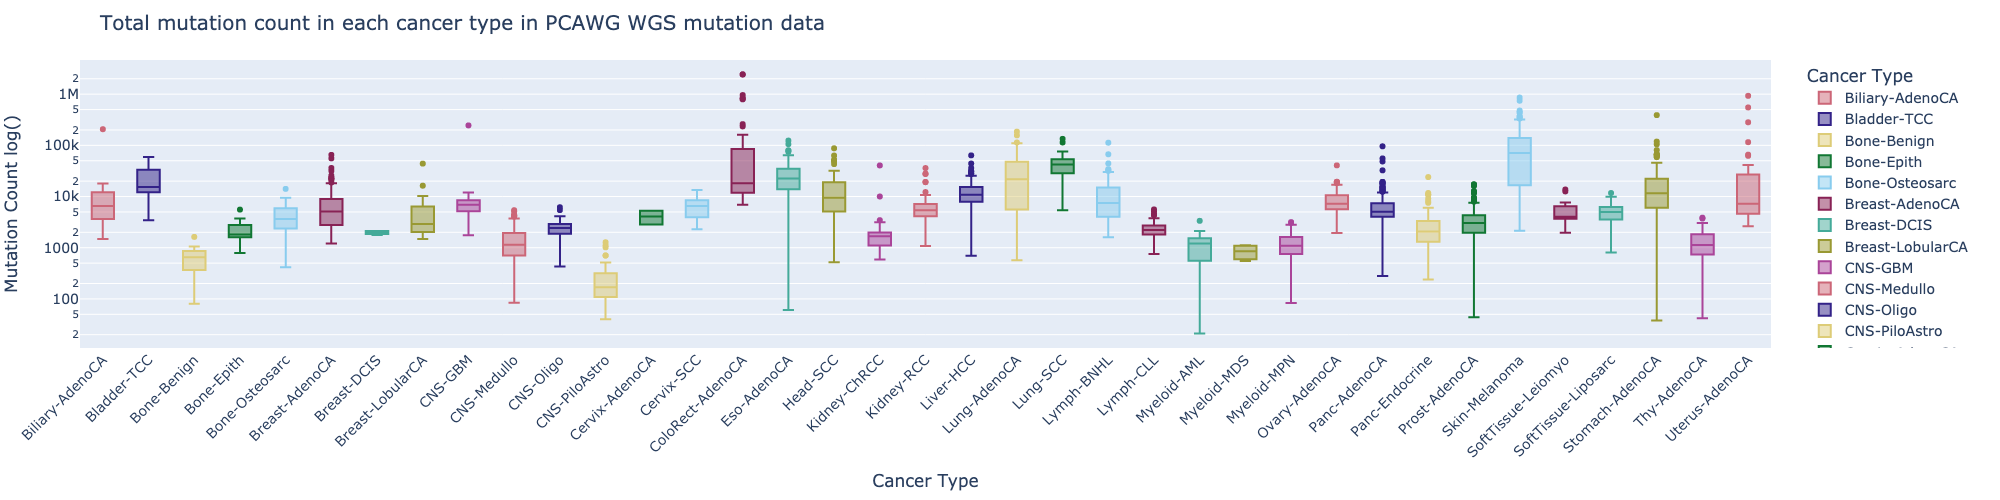

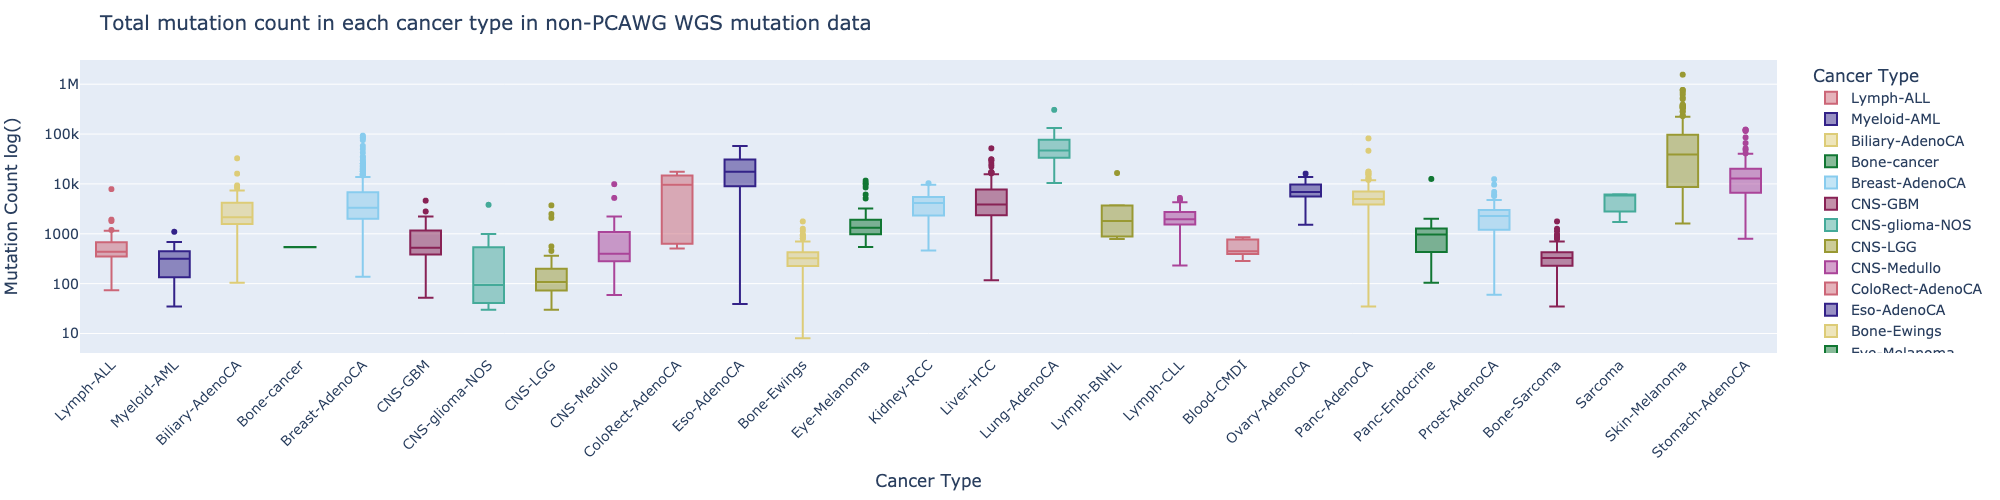

In [60]:
fig = px.box(df_wgs_mut, x="Cancer Type", y="Mutation Count", color="Cancer Type",
            color_discrete_sequence=color_palette, log_y=True)
fig.update_layout(
    title="Total mutation count in each cancer type in PCAWG WGS mutation data",
    titlefont_size = 20,
    xaxis_title="Cancer Type",
    yaxis_title="Mutation Count log()",
    font_size=14,
    width=2000,
)

fig.update_xaxes(tickangle=-45)
fig.show('png')

fig = px.box(df_non_wgs_mut, x="Cancer Type", y="Mutation Count", color="Cancer Type",
             color_discrete_sequence = color_palette ,log_y=True)
fig.update_layout(
    title="Total mutation count in each cancer type in non-PCAWG WGS mutation data",
    titlefont_size = 20,
    xaxis_title="Cancer Type",
    yaxis_title="Mutation Count log()",
    font_size=14,
    width=2000,
)

fig.update_xaxes(tickangle=-45)
fig.show('png')



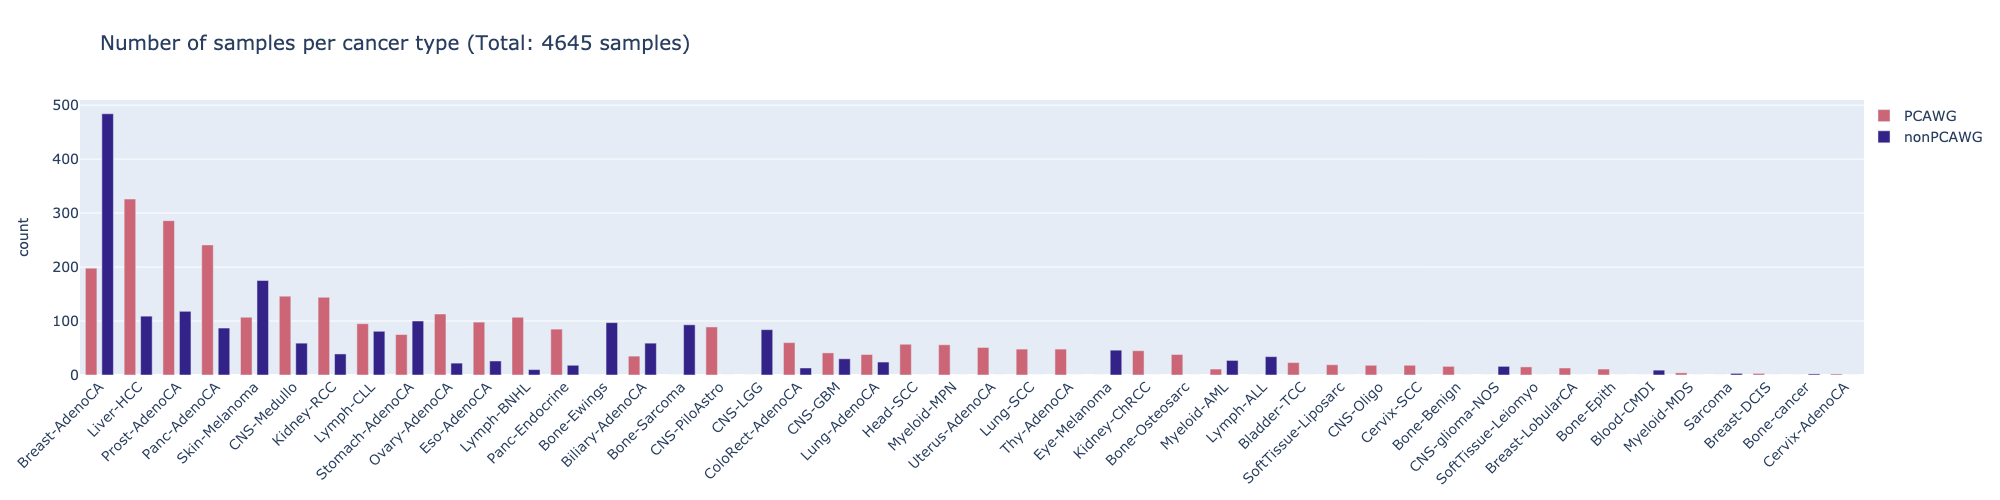

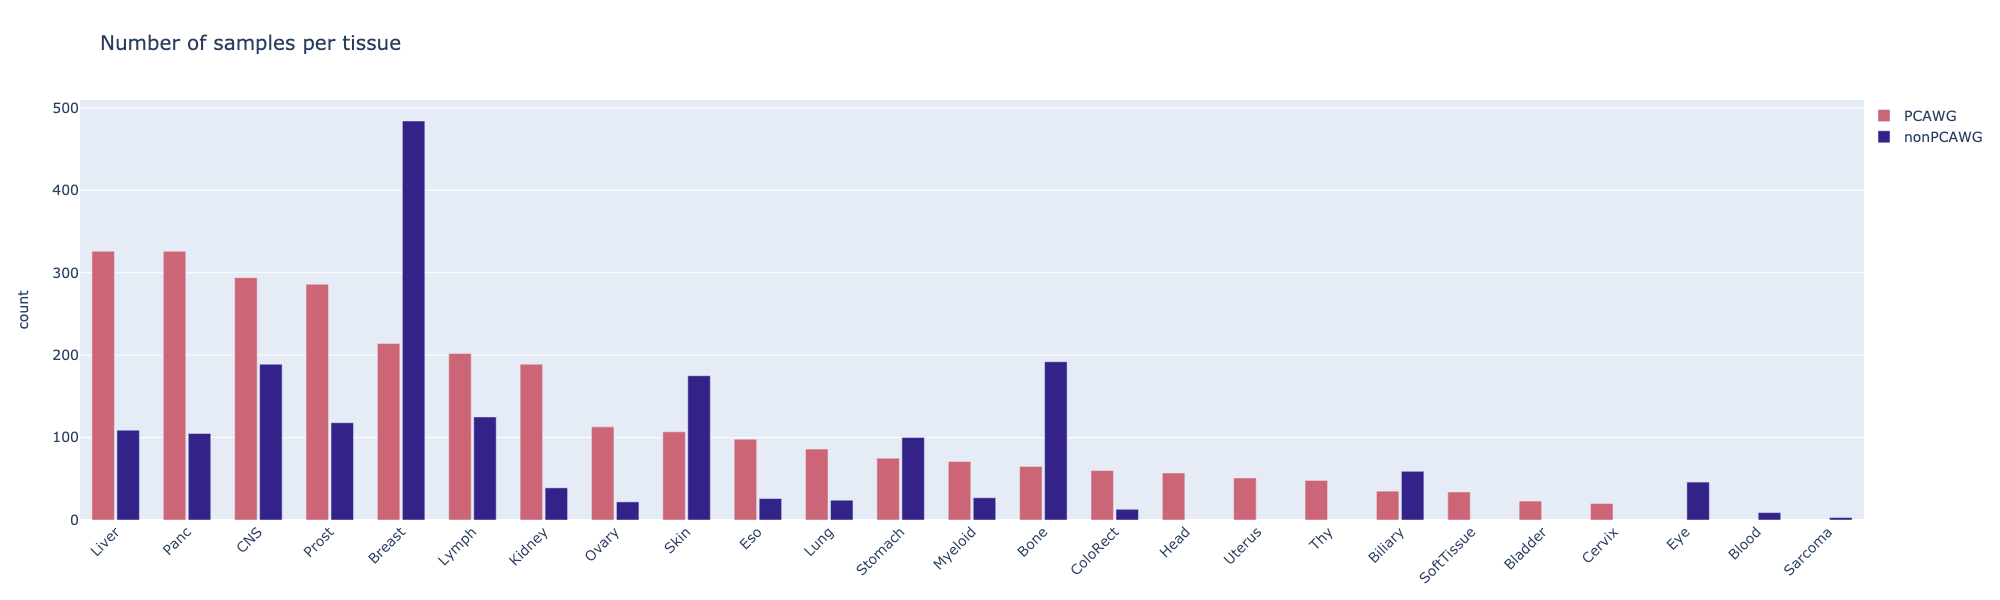

In [61]:
pcawg_counts = df_wgs_mut['Cancer Type'].value_counts()
nonpcawg_counts = df_non_wgs_mut['Cancer Type'].value_counts()
combined_counts = pcawg_counts.add(nonpcawg_counts, fill_value=0)
sorted_cancer_types = combined_counts.sort_values(ascending=False).index
pcawg_counts_sorted = pcawg_counts.reindex(sorted_cancer_types, fill_value=0)
nonpcawg_counts_sorted = nonpcawg_counts.reindex(sorted_cancer_types, fill_value=0)

# Plot
fig = go.Figure()
fig.add_trace(go.Bar(
    x=pcawg_counts_sorted.index,
    y=pcawg_counts_sorted.values,
    name='PCAWG',
    marker_color=color_palette[0]
))
fig.add_trace(go.Bar(
    x=nonpcawg_counts_sorted.index,
    y=nonpcawg_counts_sorted.values,
    name='nonPCAWG',
    marker_color=color_palette[1]
))

fig.update_layout(
    title='Number of samples per cancer type (Total: ' + str(df_wgs_mut['Cancer Type'].value_counts().sum() + df_non_wgs_mut['Cancer Type'].value_counts().sum()) + ' samples)',
    title_font_size=20,  
    xaxis_tickfont_size=14,
    yaxis=dict(title='count', title_font_size=14, tickfont_size=14,),
    legend=dict(x=1, y=1.0, font=dict(size=14)),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.3,
    height=500,
    width=2000
)

fig.update_xaxes(tickangle=-45)
fig.update_yaxes(tickfont=dict(size=14))
fig.show('png')
#################### 

fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_wgs_mut['Tissue'].value_counts().index,
    y=df_wgs_mut['Tissue'].value_counts().values,
    name='PCAWG',
    marker_color=color_palette[0]
))
fig.add_trace(go.Bar(
    x=df_non_wgs_mut['Tissue'].value_counts().index,
    y=df_non_wgs_mut['Tissue'].value_counts().values,
    name='nonPCAWG',
    marker_color=color_palette[1]
))

fig.update_layout(
    title='Number of samples per tissue',
    title_font_size=20,
    xaxis_tickfont_size=14,
    yaxis=dict(title='count', title_font_size=14, tickfont_size=14,),
    legend=dict(x=1, y=1.0, font=dict(size=14)),
    barmode='group',
    bargap=0.3,
    bargroupgap=0.1,
    height=600,
    width=2000
)

fig.update_xaxes(tickangle=-45)
fig.update_yaxes(tickfont=dict(size=14))
fig.show('png')



### Because the nonPCAWG data is over represented by some cancer types and some of the cancer types are not in PCAWG, we will use only the PCAWG data for the training, testing and validation of the models.

# Remove the the cancer types that have less than 10 samples in the PCAWG 

In the PCAWG data, we have 38 different cancer types. We will remove the cancer types that have less than 10 samples, because we need to separate the data into training and test groups within each cancer type.

In [62]:
# remove samples from cancer types that have less than 10 samples
value_counts = df_wgs_mut['Cancer Type'].value_counts()
to_remove = value_counts[value_counts < 10].index
print(f" Cancer types that will be removed from PCAWG data: {list(to_remove)}")
df_wgs_mut = df_wgs_mut[~df_wgs_mut["Cancer Type"].isin(to_remove)]

# same for the activities
value_counts = df_wgs_act['Cancer Type'].value_counts()
to_remove = value_counts[value_counts < 10].index
df_wgs_act = df_wgs_act[~df_wgs_act["Cancer Type"].isin(to_remove)]


# for the nonPCAWG_wgs_mut
#value_counts = df_non_wgs_mut['Cancer Type'].value_counts()
#to_remove = value_counts[value_counts < 10].index
#df_non_wgs_mut = df_non_wgs_mut[~df_non_wgs_mut["Cancer Type"].isin(to_remove)]


 Cancer types that will be removed from PCAWG data: ['Myeloid-MDS', 'Breast-DCIS', 'Cervix-AdenoCA']


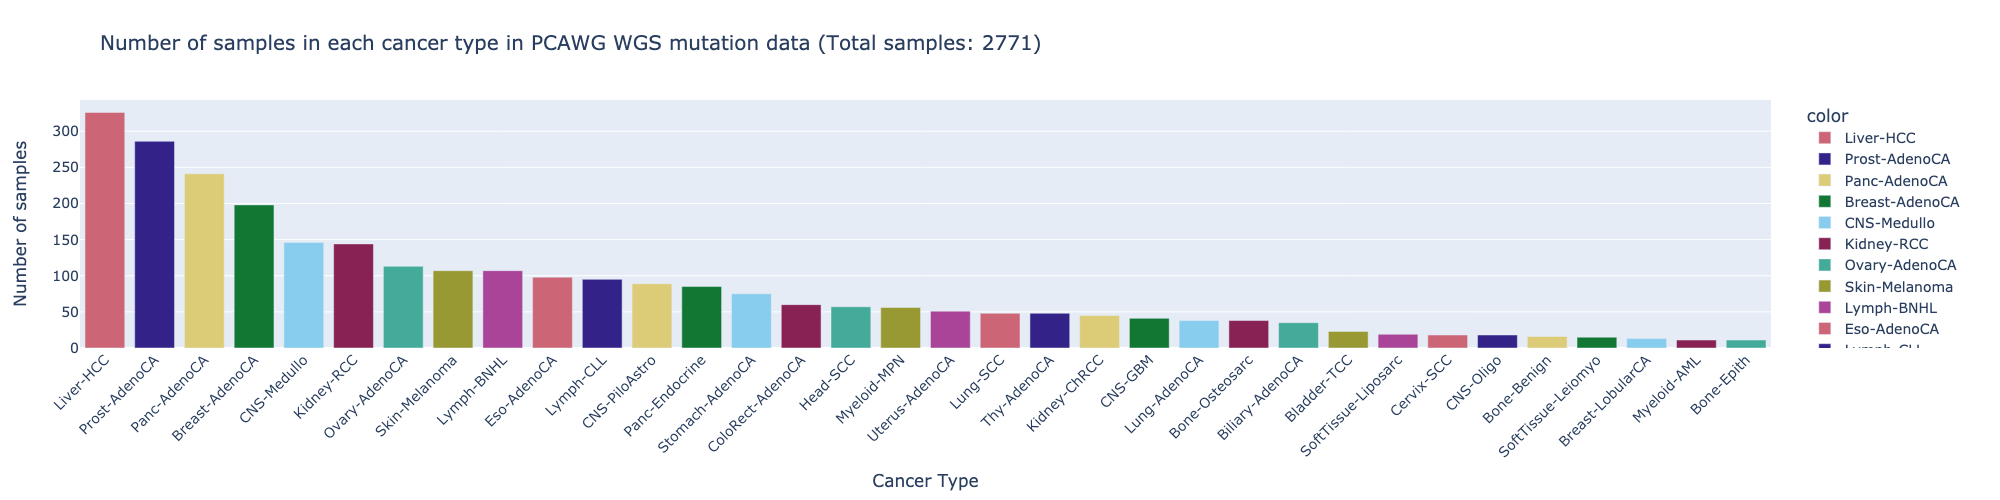

In [63]:
# plot the number of samples in each cancer type only for the PCAWG dataset
total_samples = df_wgs_mut['Cancer Type'].value_counts().sum()


fig = px.bar(df_wgs_mut['Cancer Type'].value_counts(),
             x=df_wgs_mut['Cancer Type'].value_counts().index,
             y=df_wgs_mut['Cancer Type'].value_counts().values,
             color=df_wgs_mut['Cancer Type'].value_counts().index, 
             title=f"Number of samples in each cancer type in PCAWG WGS mutation data (Total samples: {total_samples})", 
             labels={'x': 'Cancer Type', 'y': 'Number of samples',},
             color_discrete_sequence=color_palette)

fig.update_layout(
    title_font_size=20,
    font_size = 14,
    width=2000,
)

fig.update_xaxes(tickangle=-45)
fig.show('png')


# Investigating the activity data

We will first see how much zero values we have in the data. If we have a lot of zero values, we can filter out non informative features.

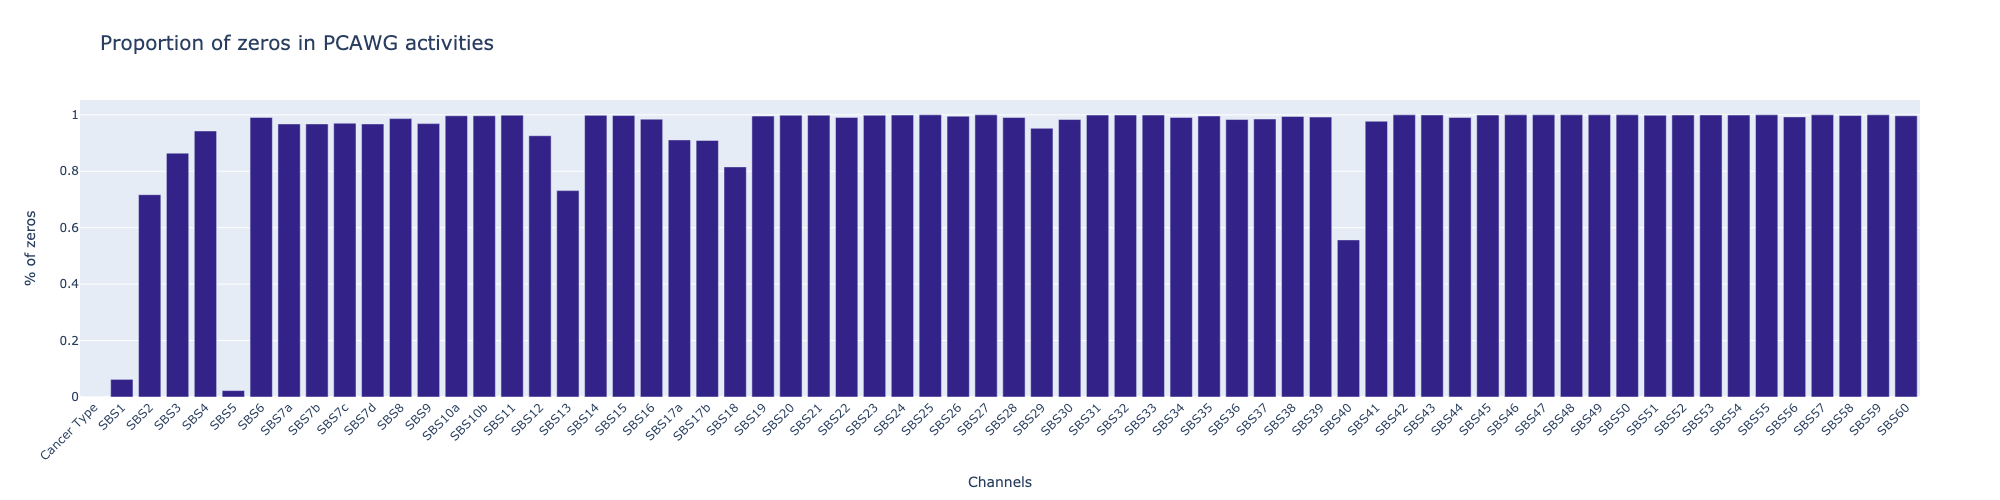

In [47]:
proportion_zeros = (df_wgs_act == 0).mean()

fig = go.Figure(data=[go.Bar(x=proportion_zeros.index, y=proportion_zeros, marker_color=color_palette[1])]) # Set the bar color here
fig.update_layout(
    title="Proportion of zeros in PCAWG activities",
    titlefont_size = 20,
    xaxis_title="Channels",
    yaxis_title="% of zeros",
    width=2000,
)
fig.update_xaxes(tickangle=-45)
fig.show('png')


# Removing activities with different thresholds:
Used threshold: 0.2, 0.5, 0.8, 0.9, which were chosen arbitrarily and so that each threshold leaves different number of activity channels.

In [11]:
# remove activities with over 20% of value 0 in the activities
df_wgs_act_20 = df_wgs_act.loc[:, (df_wgs_act==0).mean() < .2] # this is so that if the proportion of zeros is less than 20% then it is kept
df_wgs_act_70 = df_wgs_act.loc[:, (df_wgs_act==0).mean() < .7]
df_wgs_act_80 = df_wgs_act.loc[:, (df_wgs_act==0).mean() < .8]
df_wgs_act_90 = df_wgs_act.loc[:, (df_wgs_act==0).mean() < .9]


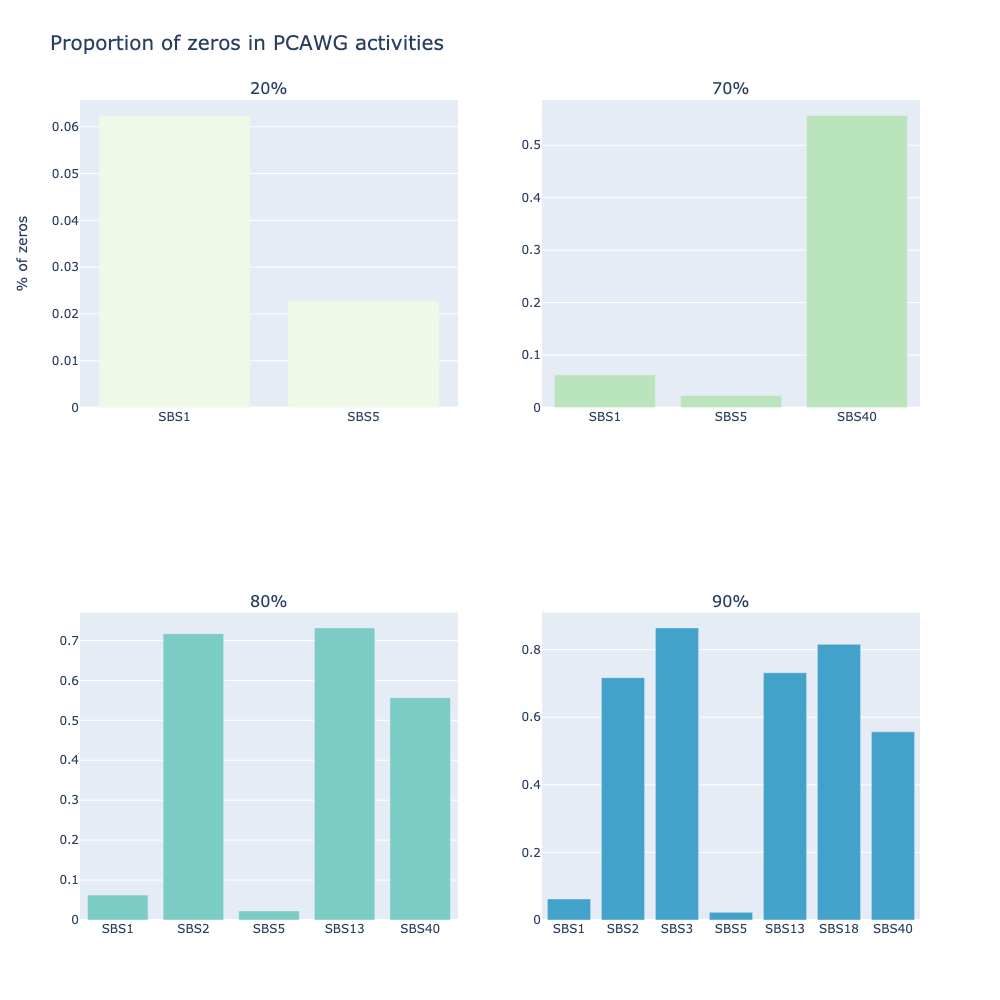

In [48]:
# plot the proportion of zeros in the all 4 df_wgs_act_ dataframes in 4 subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=("20%", "70%", "80%", "90%"))

proportion_zeros = (df_wgs_act_20.drop('Cancer Type', axis=1) == 0).mean()
fig.add_trace(go.Bar(x=proportion_zeros.index, y=proportion_zeros, marker_color='#f0f9e8'), row=1, col=1)

proportion_zeros = (df_wgs_act_70.drop('Cancer Type', axis=1) == 0).mean()
fig.add_trace(go.Bar(x=proportion_zeros.index, y=proportion_zeros, marker_color='#bae4bc'), row=1, col=2)

proportion_zeros = (df_wgs_act_80.drop('Cancer Type', axis=1) == 0).mean()
fig.add_trace(go.Bar(x=proportion_zeros.index, y=proportion_zeros, marker_color='#7bccc4'), row=2, col=1)

proportion_zeros = (df_wgs_act_90.drop('Cancer Type', axis=1) == 0).mean()
fig.add_trace(go.Bar(x=proportion_zeros.index, y=proportion_zeros, marker_color='#43a2ca'), row=2, col=2)

fig.update_layout(
    title="Proportion of zeros in PCAWG activities",
    titlefont_size = 20,
    yaxis_title="% of zeros",
    height=1000,
    showlegend=False,
    width=1000,
)

#fig.update_xaxes(tickangle=-45)
fig.show('png')



# MODEL SELECTION 

Models that we will use:

**Logistic regression models** output probabilities of an event [James]. The outputs are given by logistic function

$p(X) = \frac{e^{\beta_0 + \beta_1 X}}{1 + e^{\beta_0 + \beta_1 X}}$

where beta_0 is the intercept and beta_1 is the inverse scale parameter.

The outputs are in the range from 0 to 1. Maximum likelihood is used for the model fitting to estimate the regression coefficients. This is done by such coefficients that maximize the likelihood function. When the likelihood function is maximized, the output probabilities of events are close to unity and other probabilities are close to zero.



**Support vector machines** classifies observations by separable hyperplane [James]. When the observations are plotted to a space, the class is determined by the side of the hyperplane on which the observation is located. Support vector machines use a soft boundary, so they allow some misclassified observations. The kernel approach allows support vector machines to handle also non-linear data by allowing a non-linear decision boundary. The basic form of support vector machines is for binary classification. Nevertheless, there are modifications for supporting also multiclass classification tasks.

We considered two tree-based models: Decision Trees and Random Forest. In the decision tree approach, the predictor space is divided by a set of splitting rules [James]. These divisions are often illustrated with a tree diagram, and the classes of the observations are then determined according to their position in the tree. The decision trees are constructed by recursive binary splitting, where the splits are made by using an impurity measure. Our chosen impurity measure was the Gini index, which quantifies the variance across the classes. In addition, we picked a splitting strategy that selects the best split at each node.

The **random forest** model uses multiple trees in order to get better accuracy [James]. When constructing each tree, the splits are made using only one predictor at one split. The idea is to produce many decorrelated trees from which a concensus prediction is derived. We used the Gini index also for random forest as the impurity measure and the number of trees in the forest was set to 100.

**Naive Bayes** is a probabilistic classifier [James]. It is based on Bayes theorem,which gives the posterior probability of inclusion of an observation X=x to the class k. Naive Bayes assumes that the predictors within a given class are independent. This assumption greatly simplifies the use of the Bayes theorem. In practice, we did not expect our predictors to be independent. Nevertheless, naive Bayes often gives good results even when the modelling assumption does not hold. Thus, we decided to still test its performance on our dataset. Naive Bayes tends to add some bias, but it also reduces the variance.

**K-nearest neighbor** classifies observations by estimating the conditional distribution of Y given X [James]. An observation is assigned to a class which has the highest estimated probability. So, to classify a new observation, the k closest data points are considered. Then the most frequent class among these data points is given to the new observation. Small values of k result in very flexible decision boundary with higher risk of overfitting while large k values have more linear decision boundary with typically larger bias.

**Stochastic gradient descent** is a gradient descent method. That means that a gradient is calculated in order to find the optimum of an objective function over multiple iterations. In stochastic gradient descent, instead of using the entire dataset, only a randomly selected small sample is used in each iteration.    

**Multi layer preceptor** is a feedforward neural network. It consists of multiple layers of nodes, where each node is connected to all nodes in the next layer. The nodes in the hidden layers use activation functions to transform the input data. The output layer gives the final prediction. The model is trained by using backpropagation algorithm, which adjusts the weights of the connections between the nodes in order to minimize the error.

---
James, G., Witten, D., Hastie, T., & Tibshirani, R. (2022). An introduction to statistical learning: With applications in R. Boston: Springer.

# Split the data into training and test groups within each cancer type and scale the data using StandardScaler


In [13]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_act)


# 1. First using only the activity data 

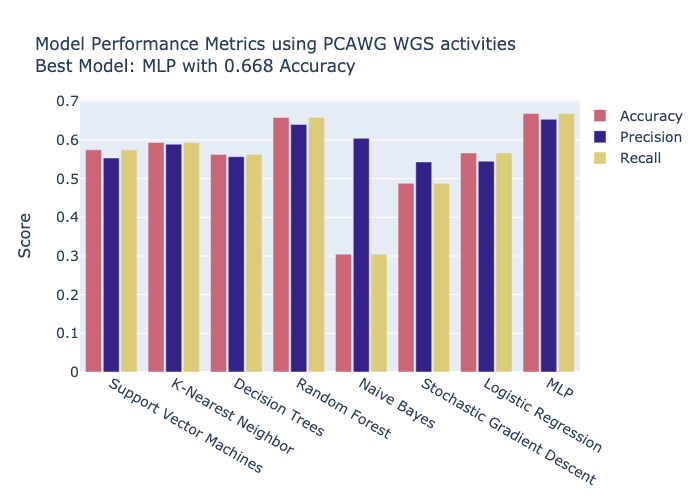

In [14]:

# Suppress all future warnings
warnings.simplefilter(action='ignore')
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_wgs_act_Results = pd.DataFrame.from_dict(results)
plot_model_performance(df_wgs_act_Results, color_palette, data = "PCAWG WGS activities")

# 2. Using only the mutation data

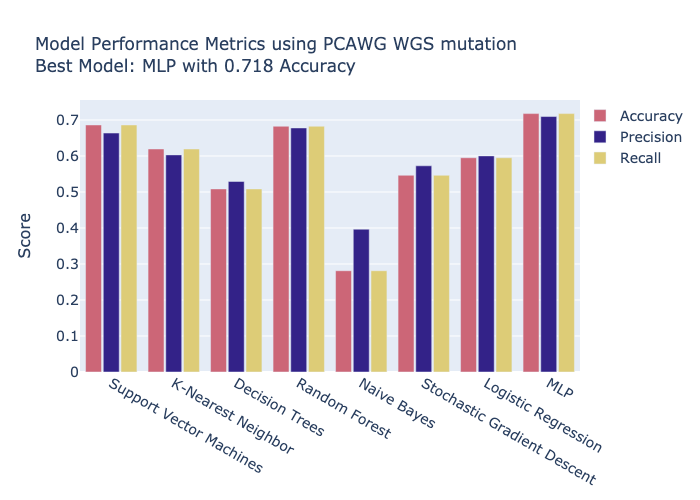

In [15]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_mut.iloc[:, :-2])

results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_wgs_results = pd.DataFrame.from_dict(results)
# plot the results using the function
plot_model_performance(df_wgs_results, color_palette, data = "PCAWG WGS mutation")

# Combining the activity with the mutation profile data

In [17]:
df_wgs_tissu = pd.merge(df_wgs_mut.drop(columns=['Cancer Type', 'Type']), df_wgs_act, left_index=True, right_index=True)
df_wgs_comb = pd.merge(df_wgs_mut.iloc[:, :-3], df_wgs_act, left_index=True, right_index=True)
df_wgs_comb_20 = pd.merge(df_wgs_mut.iloc[:, :-3], df_wgs_act_20, left_index=True, right_index=True)
df_wgs_comb_70 = pd.merge(df_wgs_mut.iloc[:, :-3], df_wgs_act_70, left_index=True, right_index=True)
df_wgs_comb_80 = pd.merge(df_wgs_mut.iloc[:, :-3], df_wgs_act_80, left_index=True, right_index=True)
df_wgs_comb_90 = pd.merge(df_wgs_mut.iloc[:, :-3], df_wgs_act_90, left_index=True, right_index=True)


## 1. Using the activities and mutation without filtering 

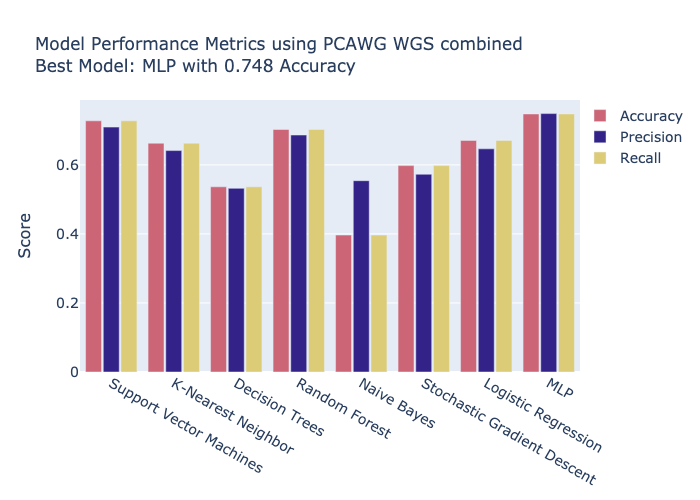

In [18]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb)
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS combined")

## 2. Using the activities and mutation with filtering 20% of the zero values

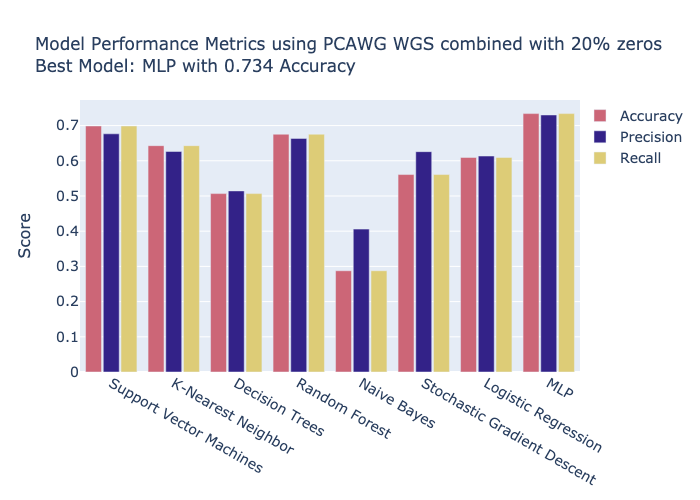

In [19]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb_20)
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS combined with 20% zeros")


# 3. Using the activities and mutation with filtering 70% of the zero values

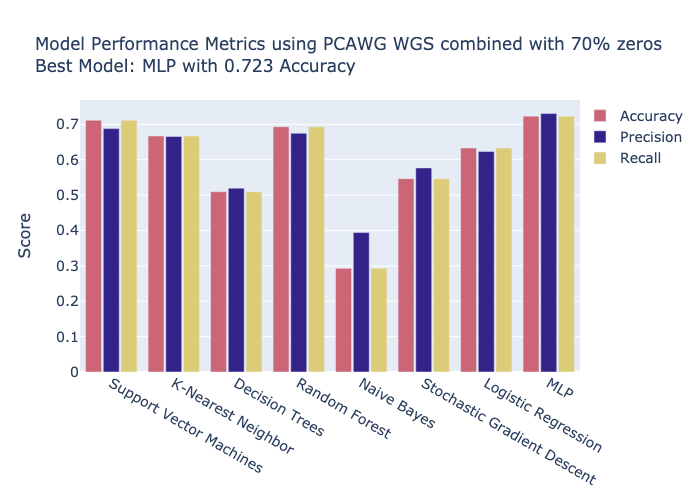

In [20]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb_70)
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS combined with 70% zeros")


# 4. Using the activities and mutation with filtering 90% of the zero values

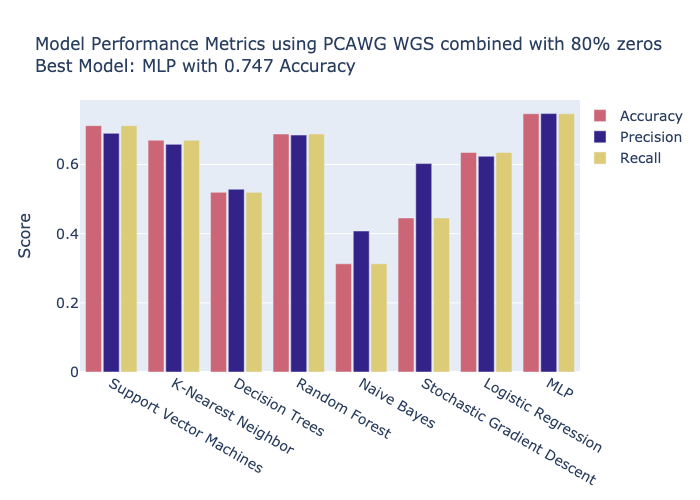

In [21]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb_80)
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS combined with 80% zeros")


# 5. Using the activities and mutation with filtering 90% of the zero values

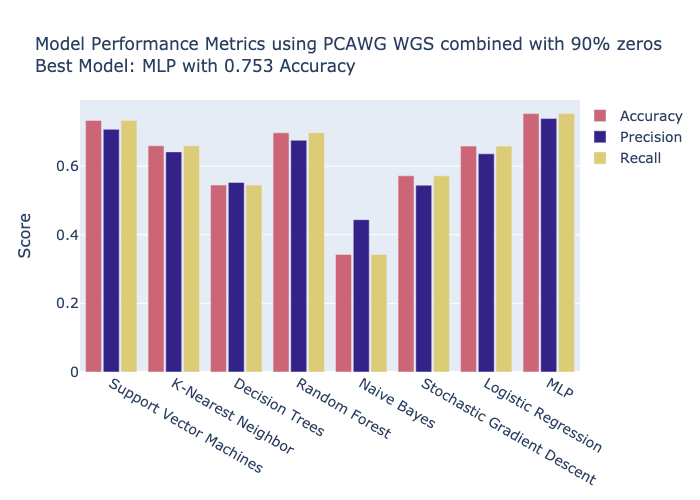

In [22]:
X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb_90)
results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS combined with 90% zeros")

In [23]:
feature_importance_rf = compute_feature_importance(models['Random Forest'], X_test_scaled, y_test)

Since the best model is MLP we try to optimize the hyperparameters of the model using RandomizedSearchCV to see if we can improve the model performance.

In [ ]:

X_train_scaled,X_test_scaled,y_train, y_test = func_split_scaler(df_wgs_comb)

X = X_train_scaled
y = y_train

mlp = MLPClassifier(max_iter=1200, random_state=random_state)

parameter_space = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu', 'logistic', 'identity'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'momentum': [0.9, 0.5],
    'tol': [0.0001, 0.001],
    'n_iter_no_change': [10, 20],
}

from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(mlp, parameter_space, n_iter=100, n_jobs=-1, cv=5, scoring='accuracy')

clf.fit(X, y)


print('Best parameters found:\n', clf.best_params_)

print("Test set accuracy: %0.3f" % clf.score(X_test_scaled, y_test))




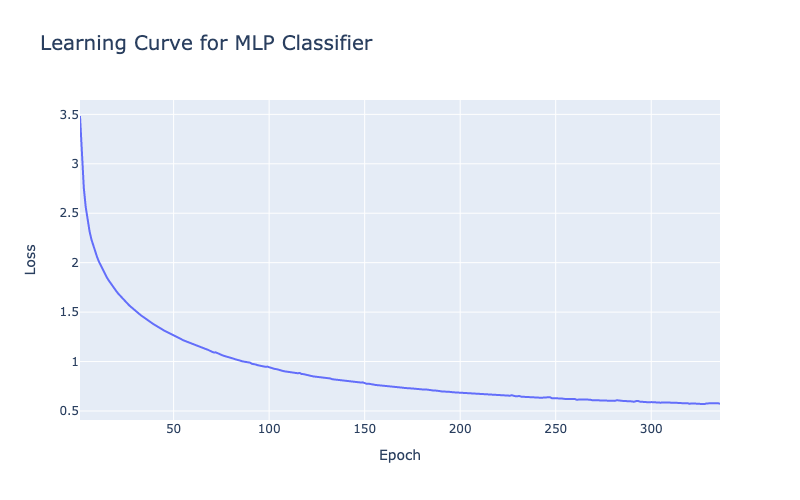

In [25]:
# plot the loss curve 

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, len(clf.best_estimator_.loss_curve_)+1), y=clf.best_estimator_.loss_curve_, mode='lines', name='Training Loss'))
fig.update_layout(
    title="Learning Curve for MLP Classifier",
    titlefont_size = 20,
    xaxis_title="Epoch",
    yaxis_title="Loss",
    font=dict(
        size=12
    ),
    height=500,
    width=800
)
fig.show('png')






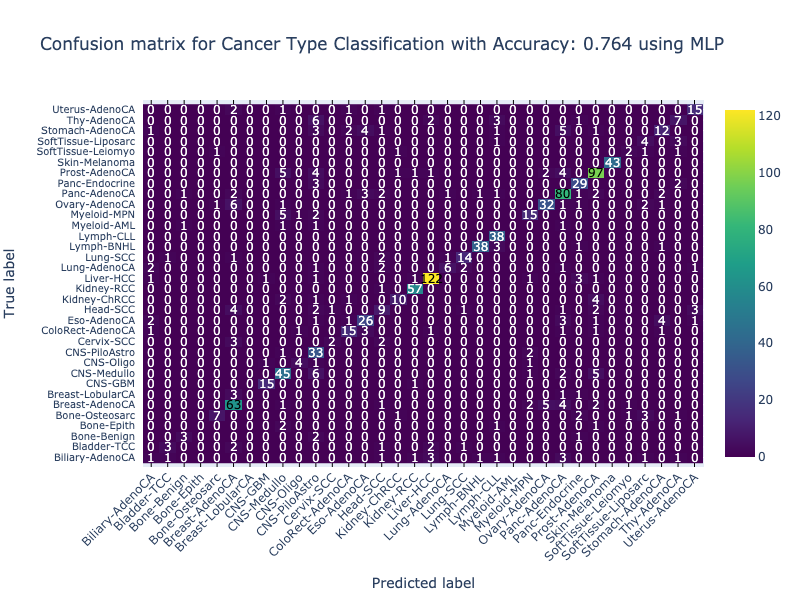

In [26]:

mlp = MLPClassifier(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                    activation=clf.best_params_['activation'],
                    solver=clf.best_params_['solver'], alpha=clf.best_params_['alpha'],
                    learning_rate=clf.best_params_['learning_rate'], max_iter=1200, learning_rate_init=clf.best_params_['learning_rate_init'],
                    momentum=clf.best_params_['momentum'], tol=clf.best_params_['tol'], n_iter_no_change=clf.best_params_['n_iter_no_change'],
                    random_state=42)

mlp.fit(X_train_scaled, y_train)
predictions = mlp.predict(X_test_scaled)
y_pred = mlp.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)

x = list(clf.classes_)
y = list(clf.classes_)

fig = ff.create_annotated_heatmap(z=cm, x=x, y=y, colorscale='Viridis', showscale=True)
fig.update_layout(
    title_text=f"Confusion matrix for Cancer Type Classification with Accuracy: {accuracy_score(y_test, y_pred):.3f} using MLP",
    xaxis=dict(title='Predicted label', side='bottom'),  
    yaxis=dict(title='True label'),
    autosize = False,
    width = 800,
    height = 600,
    margin=dict(l=50, r=50, b=100, t=100),
)
fig.update_xaxes(tickangle=-45)
fig.update_yaxes(tickfont=dict(size=10))

fig.show('png')



Cancer type classification: 
* Cancers with similar tissue type get sometimes mixed up: Esophageal and Colorectal cancers are classified as Stomach cancers (all cancers of the digestive tract). Different subtypes of breast cancer get mixed up (Breast LobularCA classified as Breast AdenoCA)
* Gynaecological cancers (breast and ovary) get also mixed up
* Cancers with very little sample size to begin with are difficult to classify (for example Bone-Epith)

=> Tissues with similar exposures (digestive tract: food, gynaecological: hormonal) are likely to acquire similar mutation profiles and are more difficult to classify based on mutational profile alone.

# Feature importance for the two best models MLP and RF using permutation feature importance

In [27]:
feature_importance_mlp = compute_feature_importance(mlp, X_test_scaled, y_test)


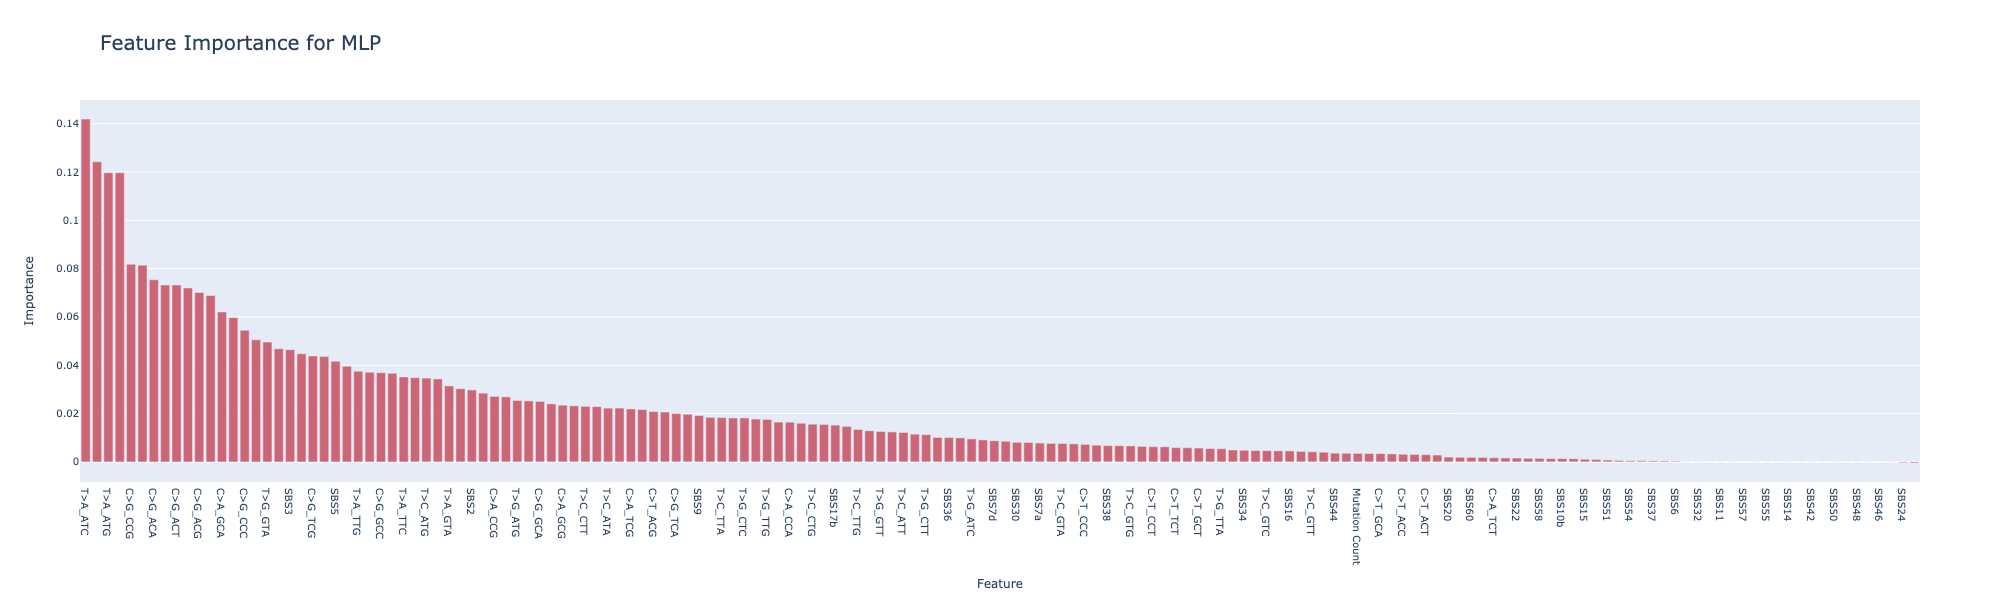

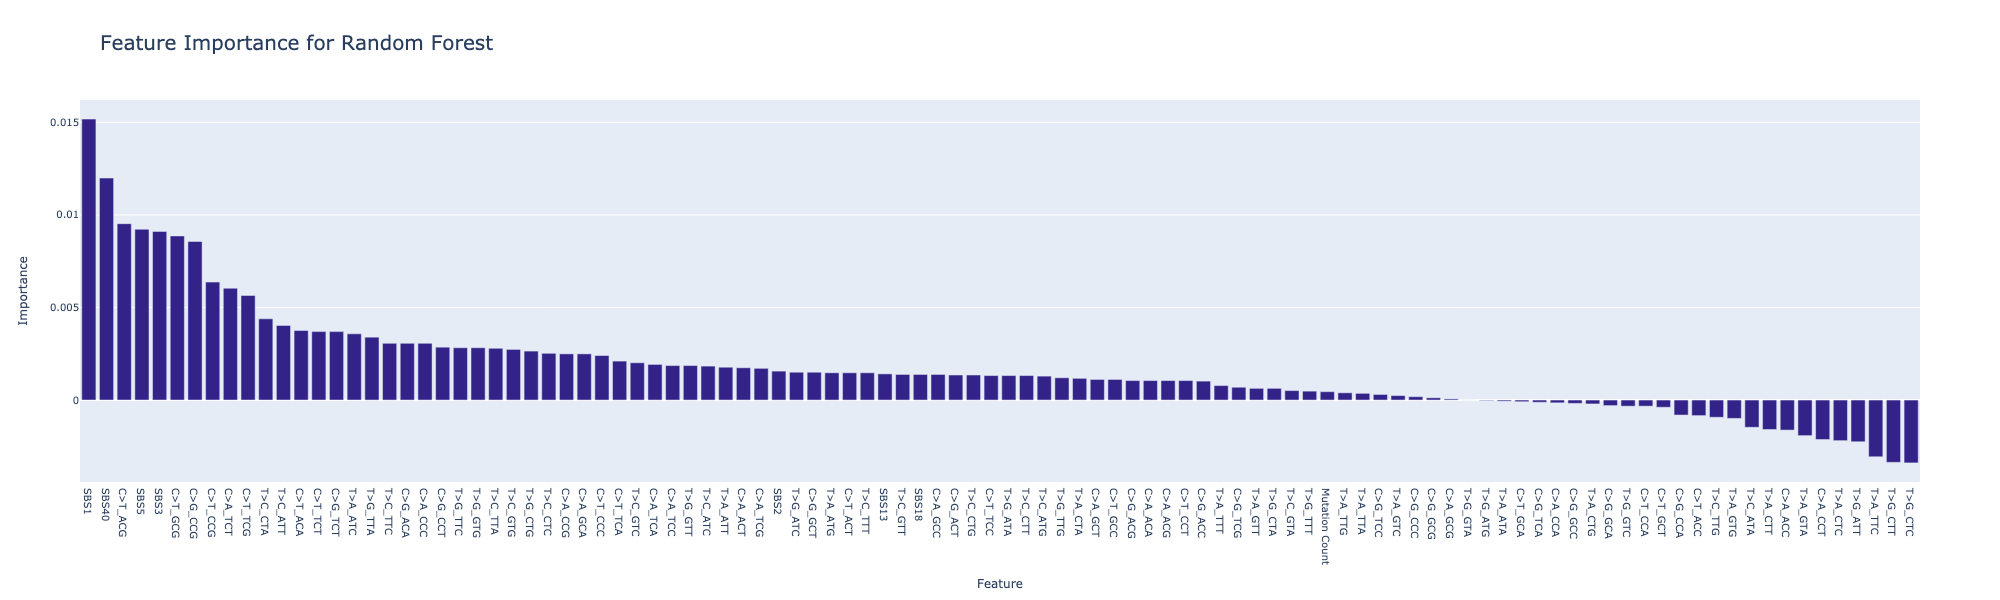

In [64]:
feature_importance_mlp = feature_importance_mlp.sort_values(by='Importance', ascending=False)
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

fig = go.Figure()
fig.add_trace(go.Bar(x=feature_importance_mlp['Feature'], y=feature_importance_mlp['Importance'], marker_color=color_palette[0]))
fig.update_layout(
    title="Feature Importance for MLP",
    titlefont_size = 20,
    xaxis_title="Feature",
    yaxis_title="Importance",
    font=dict(
        size=10
    ),
    height=600,
    width=2000
)
fig.show('png')

fig = go.Figure()
fig.add_trace(go.Bar(x=feature_importance_rf['Feature'], y=feature_importance_rf['Importance'], marker_color=color_palette[1]))
fig.update_layout(
    title="Feature Importance for Random Forest",
    titlefont_size = 20,
    xaxis_title="Feature",
    yaxis_title="Importance",
    font=dict(
        size=10
    ),
    height=600,
    width=2000
)


fig.show('png')



Important features for MLP (and RF): 

* In general a few important activity signatures, SBS1 and SBS40, and several C>A or C>T mutations among important features 

* SBS1: Age-related, reflects number of mitosis a cell has undergone, C>T mutations only.
* SBS40:  Age-related, flat signature (i.e. has many different mutation types at somewhat equal frequencies).

* C>A mutations: rich in activity signatures that are related to tobacco smoking.
* C>T mutations: age-related (as expected based on overlap with SBS1)

* In general all features have very low importance 

# VALIDATION using K-fold cross validation


In [29]:

selected_models = {
    'Decision Trees': DecisionTreeClassifier(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001,
                        solver='adam',  random_state=21,tol=0.000000001)
}

X_combined = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

results_kfold = perform_kfold_cv(X_combined, y_combined, models, random_state=random_state)
print("Results from k-fold cross-validation:")
print(results_kfold)

Results from k-fold cross-validation:
                             Accuracy  Precision    Recall
Support Vector Machines      0.754241   0.749518  0.754241
K-Nearest Neighbor           0.657516   0.658963  0.657516
Decision Trees               0.561164   0.585590  0.561164
Random Forest                0.732222   0.718338  0.732222
Naive Bayes                  0.408521   0.560597  0.408521
Stochastic Gradient Descent  0.585363   0.614113  0.585363
Logistic Regression          0.697950   0.679043  0.697950
MLP                          0.767575   0.781036  0.767575


# Trying then to predict the cancer tissue type using the best model and the PCAWG data

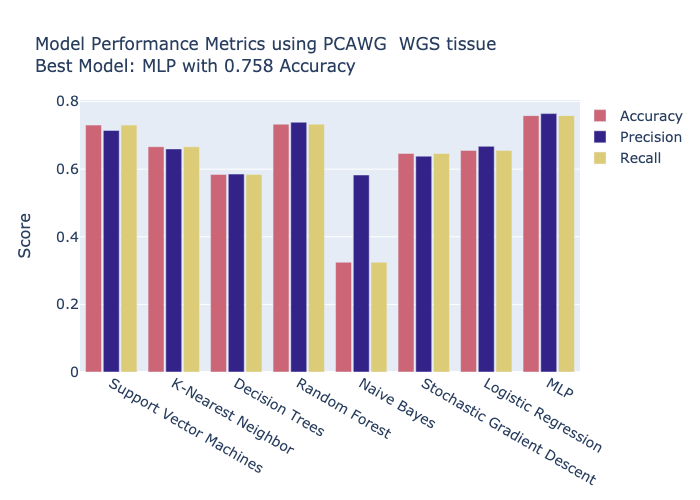

In [44]:
# split the data into train and test using the sklearn train_test_split function
X = df_wgs_tissu.drop(['Cancer Type', 'Tissue'], axis = 1)
y = df_wgs_tissu['Tissue']
X_train_scaled,X_test_scaled,y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y , random_state=random_state)
# scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled.values), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled.values), columns=X_test_scaled.columns, index=X_test_scaled.index)


results = train_models(X_train_scaled,X_test_scaled,y_train, y_test, models)
df_results = pd.DataFrame.from_dict(results)
plot_model_performance(df_results, color_palette, data = "PCAWG WGS tissue")

# Optimizing the hyperparameters of the model using RandomizedSearchCV to see if we can improve the model performance.

In [ ]:
X = df_wgs_tissu.drop(['Cancer Type', 'Tissue'], axis = 1)
y = df_wgs_tissu['Tissue']
X_train_scaled,X_test_scaled,y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y , random_state=random_state)
# scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled.values), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled.values), columns=X_test_scaled.columns, index=X_test_scaled.index)


X = X_train_scaled
y = y_train

mlp = MLPClassifier(max_iter=1200, random_state=random_state)

parameter_space = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['tanh', 'relu', 'logistic', 'identity'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'momentum': [0.9, 0.5],
    'tol': [0.0001, 0.001],
    'n_iter_no_change': [10, 20],
}

from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(mlp, parameter_space, n_iter=100, n_jobs=-1, cv=5, scoring='accuracy')

clf.fit(X, y)


print('Best parameters found:\n', clf.best_params_)

print("Test set accuracy: %0.3f" % clf.score(X_test_scaled, y_test))

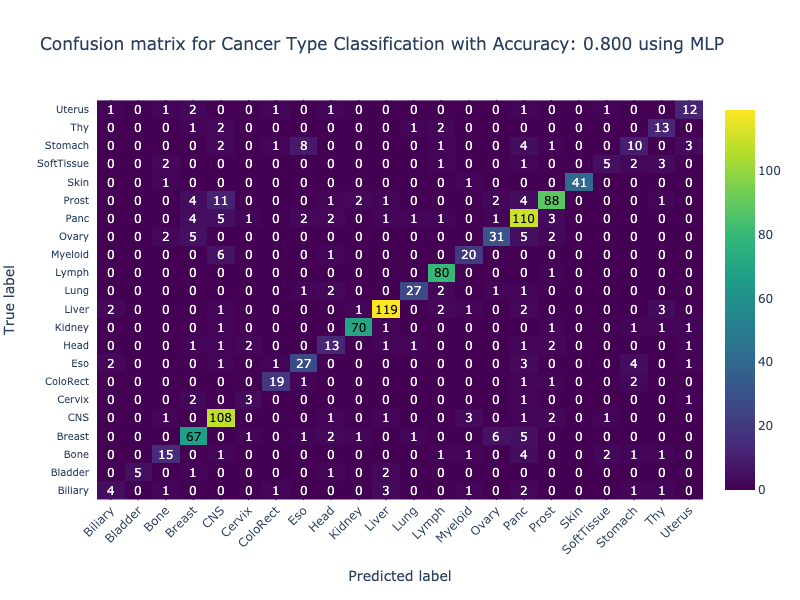

In [67]:
mlp = MLPClassifier(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                    activation=clf.best_params_['activation'],
                    solver=clf.best_params_['solver'], alpha=clf.best_params_['alpha'],
                    learning_rate=clf.best_params_['learning_rate'], max_iter=1200, learning_rate_init=clf.best_params_['learning_rate_init'],
                    momentum=clf.best_params_['momentum'], tol=clf.best_params_['tol'], n_iter_no_change=clf.best_params_['n_iter_no_change'],
                    random_state=42)

mlp.fit(X_train_scaled, y_train)
predictions = mlp.predict(X_test_scaled)
y_pred = mlp.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred, labels=mlp.classes_)

x = list(clf.classes_)
y = list(clf.classes_)

fig = ff.create_annotated_heatmap(z=cm, x=x, y=y, colorscale='Viridis', showscale=True)
fig.update_layout(
    title_text=f"Confusion matrix for Cancer Type Classification with Accuracy: {accuracy_score(y_test, y_pred):.3f} using MLP",
    xaxis=dict(title='Predicted label', side='bottom'),  
    yaxis=dict(title='True label'),
    autosize = False,
    width = 800,
    height = 600,
    margin=dict(l=50, r=50, b=100, t=100),
)
fig.update_xaxes(tickangle=-45)
fig.update_yaxes(tickfont=dict(size=10))

fig.show('png')

Again we can see that Prostate, Stomach and Breast cancers are difficult to classify.